In [1]:
# hide
%reload_ext autoreload
%autoreload 2

In [3]:
from dataFunction import *
# import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from HE_functions import *
from typing import Generator
import tenseal as ts
from lrClass import LR
from simulationDataUtils import *

random.seed(11007303)
np.random.seed(2021)

In [12]:
# # Parameters
# n_clients = 10
# n_features = 10
# n_observations = 500

n_option = 1
n_clients = 2
n_features =2 


In [4]:
# glob_model = LR(n_features)
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()


        

In [9]:
def KL_divergence_multi(dist1, dist2):
    mu1 = dist1[0]
    cov1 = dist1[1]

    mu2 = dist2[0]
    cov2 = dist2[1]

    mu_dif = mu2 - mu1
    inv_cov2 = np.linalg.inv(cov2)
    trace_cov12 = np.matrix.trace(inv_cov2*cov1)
    det_cov1 = np.linalg.det(cov1)
    det_cov2 = np.linalg.det(cov2)

    return 1/2 *( mu_dif.T @ inv_cov2 @ mu_dif+trace_cov12-np.log(det_cov1/det_cov2)-len(mu1))


In [26]:
def KL_divergence_norm(dist1, dist2):
    mu1 = dist1[0]
    cov1 = dist1[1]

    mu2 = dist2[0]
    cov2 = dist2[1]

    return 1/2 *( (mu2-mu1)**2/cov2+cov1/cov2-np.log(cov1/cov2)-1)


In [ ]:
val, cnt = np.unique(outcomes, return_counts=True)
prop = cnt / len(outcomes)

In [27]:
plt.rcParams.update({'font.size': 12})

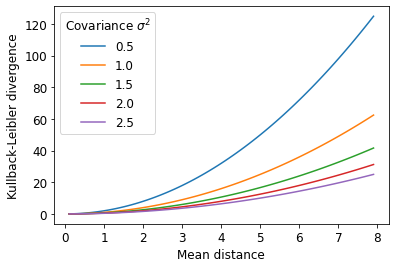

In [29]:
cov_values =np.arange(0.5, 3, 0.5)
mean_distance = np.arange(0.1, 8.0, 0.1)
kl_values = []
mu = np.random.randint(-10,10,size=2)
for cov_v in cov_values:
    kl_values = []
    for m in mean_distance:
        cov = np.diag([cov_v]*n_features)
        kl_values.append(KL_divergence([mu, cov], [mu+(m), cov]))
    plt.plot(mean_distance,kl_values)
    plt.xlabel('Mean distance')
    plt.ylabel('Kullback-Leibler divergence')
# plt.tight_layout(pad=2)
plt.legend(cov_values.round(1), title = "Covariance $\sigma^2$")
# plt.title('Mean value:{}, KL divergence vs Mean distance'.format(mu))
# plt.set_facecolor('xkcd:salmon')
plt.savefig('mean_cov_kl.png',bbox_inches='tight',  dpi=300)
plt.show()
    # print('cov: {}, KL:{}'.format(cov_v, KL_divergence([np.ones(n_features), cov], [np.ones(n_features)*1.1, cov])))

In [137]:
# N_Options = [10,20,50]
N_Clients = [2,5,10,30]
N_Features = [2,5,10,15,20]
N_Observations = [100,200,500]
N_Options = [10]
# N_Clients = [10]
# N_Features = [10]
# N_Observations = [500]
# cov_sum = [6, 10, 20, 25]
cov_scale = [1 , 5, 10,50, 100, 400, 600, 1000]


iter = 0
Total_dict = {}
for n_option in N_Options:
    for n_clients in N_Clients:
        for cov in cov_scale:
            cov_random_options = np.random.default_rng().uniform(3, (3+cov), size=(n_option, n_clients))
            for n_features in N_Features:
                glob_model = LR(n_features)
                for n_observations in N_Observations:
                    parameters = {}
                    parameters['n_option'] = n_option
                    parameters['n_clients'] = n_clients
                    parameters['n_features'] = n_features
                    parameters['n_observations'] = n_observations
                    parameters['cov_sum'] = cov
                    
                
                    KL_overview = []
                    best_acc_overview = []
                    KL_dict = {}
                    for option in cov_random_options:
                        # for mu in mu_options:
                        # glob_model = LR(n_features)
                        # print(glob_model.state_dict())
                        client_distribution_list = make_clients_dist(option, n_clients, n_features)
                        KL_df, KL_sym_df = make_KL_matrices(n_clients, client_distribution_list)
                        clients = define_clients(client_distribution_list, n_observations,n_features,glob_model)
                        validation_X_set, validation_y_set = make_validation_sets(clients)
                        fl_glob_model = copy.deepcopy(glob_model)
                        best_epoch, best_acc, model_dict, final_results = FL_proces(clients, validation_X_set, validation_y_set, ctx_eval, fl_glob_model, iters= 100)
                        KL_mean = np.array(KL_sym_df)[np.triu_indices(n_clients, k=1)].mean()
                        print('KL divergence with cov: {}, KL:{}, cov_scale:{}, n_clients:{}, n_features:{}'.format(option,  KL_mean, cov, n_clients, n_features))
                        print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  
                        # print(model_dict)
                        # save_results.append([KL_sym_df[0][1],best_acc])
                        KL_overview.append(KL_mean)
                        best_acc_overview.append(float(best_acc))
                    KL_dict['KL'] = KL_overview
                    KL_dict['acc'] = best_acc_overview
                    
                    summary = {}
                    summary['parameters'] = parameters
                    summary['results'] = KL_dict
                    Total_dict[iter] = summary
                    iter += 1
                        
                        # print(final_results)

KL divergence with cov: [3.19510517 3.04823879], KL:0.001107339094147064, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 0.9750000238418579
KL divergence with cov: [3.39488402 3.39281657], KL:1.85546623399091e-07, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 0.9750000238418579
KL divergence with cov: [3.47136438 3.6331453 ], KL:0.0010376278274146777, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 98, acc: 0.6000000238418579
KL divergence with cov: [3.73161719 3.128145  ], KL:0.015599136866839225, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 0.5
KL divergence with cov: [3.39218351 3.520157  ], KL:0.000685754440095887, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 0.75
KL divergence with cov: [3.96406134 3.2086746 ], KL:0.022430692301130595, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 1.0
KL divergence with cov: [3.60924561 3.52120339], KL:0.0003049610802149383, cov_scale:1, n

KeyboardInterrupt: 

In [483]:
iter = 0
# pbar = tqdm(total=6000)   
for n_clients in N_Clients:
    for n_features in N_Features:
        for mean_dist in mean_distance:
            glob_model = LR(n_features)
            for n_observations in N_Observations:
                for mc in monte_carlo_reps:
                    print('inter:{}, mean dist: {}, n_observation:{}, n_clients:{}, n_features:{}, mc:{}'.format(iter, mean_dist, n_observations, n_clients,  n_features, mc))
                    # make_clients_dist(mean_dist, n_clients, n_features)
                iter += 1
                    # pbar.update(1) 

inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:0
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:1
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:2
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:3
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:4
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:5
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:6
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:7
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:8
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:9
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:10
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:11
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:12
inter:0, 